# Setup

In [1]:
import plotly.io as pio
try:
    import google.colab
    print("Running as a Colab notebook")
    pio.renderers.default = "colab"
    %pip install transformer-lens fancy-einsum
    %pip install -U kaleido # kaleido only works if you restart the runtime. Required to write figures to disk (final cell)
except:
    print("Running as a Jupyter notebook")
    pio.renderers.default = "vscode"
    from IPython import get_ipython
    ipython = get_ipython()

Running as a Jupyter notebook


In [2]:
import torch
from fancy_einsum import einsum
from transformer_lens import HookedTransformer, HookedTransformerConfig, utils, ActivationCache
from torchtyping import TensorType as TT
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import einops
from typing import List, Union, Optional
from functools import partial
import pandas as pd
from pathlib import Path
import urllib.request
from bs4 import BeautifulSoup
from tqdm import tqdm
from datasets import load_dataset
import os
import json

os.environ["TOKENIZERS_PARALLELISM"] = "false" # https://stackoverflow.com/q/62691279
torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
!pip install circuitsvis
import circuitsvis as cv


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [4]:
pio.renderers.default='vscode'

def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def imshow_fig(tensor, renderer=None, **kwargs):
    return px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs)
def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [5]:
model = HookedTransformer.from_pretrained(
    "gpt2-large",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
    device=device,
)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-large into HookedTransformer


# Neuron Exploration

In [6]:
def get_head_attribution(cache, tokens, neuron):
    # Get prompt lengths
    pad_token = bos_token = 50256 # This is true for GPT-2
    prompt_lengths = (torch.logical_and(tokens != pad_token, tokens != bos_token)).sum(dim=-1)

    # Get the correct last-seq for each prompt (since they are padded, the last seq position differs for each prompt)
    head_output = cache.stack_head_results()
    expanded_index_tensor = prompt_lengths.unsqueeze(0).unsqueeze(-1).unsqueeze(-1).expand(head_output.shape[0], head_output.shape[1], 1, head_output.shape[-1])
    head_output_last_seq = torch.gather(head_output, 2, expanded_index_tensor).squeeze(2)

    # Get dot product of neuron with each head's output

    layer, no = neuron
    neuron_w_in = model.W_in[layer, :, no]
    head_attribution = einsum("head batch weight, weight->batch head", head_output_last_seq, neuron_w_in)
    head_attribution = head_attribution[:, :layer*model.cfg.n_heads] # Filter for only heads before the neuron
    return head_attribution # Shape [batch, head]

In [7]:
# Load Dataset
from importlib import reload
import activating_dataset
reload(activating_dataset)
from activating_dataset import ActivatingDataset
from datasets import load_dataset

# Load Neuron
try:
    dataset = load_dataset("NeelNanda/pile-10k", split="train")
except: # this is a hack to let me work offline
    import pickle
    with open("dataset.pkl", "rb") as f:
        dataset = pickle.load(f)

data = ActivatingDataset('data/neuron_20_examples_2.json', dataset)
data.remove_prompts_longer_than(100)
neurons = list(data.markers.keys())

Using custom data configuration NeelNanda--pile-10k-72f566e9f7c464ab
Found cached dataset parquet (/Users/clementneo/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [11]:
dataset[5]['meta']

{'pile_set_name': 'StackExchange'}

In [58]:
num_sets = []

for neuron in neurons:
    trunc_prompts, prompts_metadata = data.load_truncated_prompts(model, neuron)
    num_sets.append(len(set(prompts_metadata)))

# Do counts in num_sets
from collections import Counter
counter = Counter(num_sets)
# print counter by key ascending order
for key, count in sorted(counter.items()):
    print(f"{key}: {count}")


2: 4
3: 10
4: 15
5: 12
6: 6
7: 2
9: 1


In [8]:
save_files = False

In [11]:
head_attribution_dict = {}
head_attribution_list = []

for neuron in tqdm(neurons):
    # Load and Truncate Prompts (slightly cursed way of string -> token -> truncated tokens -> string)
    trunc_prompts, prompts_metadata = data.load_truncated_prompts(model, neuron)

    # Run head attribution
    tokens = model.to_tokens(trunc_prompts, prepend_bos=True).to(device=device)
    original_logits, cache = model.run_with_cache(tokens, )

    # # Prepare prompts by heads
    head_attribution = get_head_attribution(cache, tokens, neuron)
    head_attribution_list.append(head_attribution)
    continue
    _, top_heads = torch.topk(head_attribution, k=3, dim=-1)
    top_heads_list = top_heads.tolist()

    head_results = {}
    for i, prompt in enumerate(trunc_prompts):
        head_results[prompt] = top_heads_list[i]

    head_attribution_dict[str(neuron)] = head_results
    break

# Save results
if save_files:
    with open("head_attribution_dict.json", "w") as f:
        json.dump(head_attribution_dict, f)
    save_files = False

  0%|          | 0/50 [00:00<?, ?it/s]

Tried to stack head results when they weren't cached. Computing head results now


  2%|▏         | 1/50 [00:12<10:11, 12.47s/it]

Tried to stack head results when they weren't cached. Computing head results now


  4%|▍         | 2/50 [00:35<14:55, 18.65s/it]

Tried to stack head results when they weren't cached. Computing head results now


  6%|▌         | 3/50 [00:54<14:36, 18.65s/it]

Tried to stack head results when they weren't cached. Computing head results now


  8%|▊         | 4/50 [01:15<15:00, 19.58s/it]

Tried to stack head results when they weren't cached. Computing head results now


 10%|█         | 5/50 [01:25<12:07, 16.17s/it]

Tried to stack head results when they weren't cached. Computing head results now


 12%|█▏        | 6/50 [01:35<10:29, 14.32s/it]

Tried to stack head results when they weren't cached. Computing head results now


 14%|█▍        | 7/50 [01:57<11:56, 16.66s/it]

Tried to stack head results when they weren't cached. Computing head results now


 16%|█▌        | 8/50 [02:19<12:48, 18.30s/it]

Tried to stack head results when they weren't cached. Computing head results now


 18%|█▊        | 9/50 [02:46<14:23, 21.06s/it]

Tried to stack head results when they weren't cached. Computing head results now


 20%|██        | 10/50 [03:17<16:10, 24.26s/it]

Tried to stack head results when they weren't cached. Computing head results now


 22%|██▏       | 11/50 [03:42<15:46, 24.28s/it]

Tried to stack head results when they weren't cached. Computing head results now


 24%|██▍       | 12/50 [03:54<12:59, 20.51s/it]

Tried to stack head results when they weren't cached. Computing head results now


 26%|██▌       | 13/50 [04:07<11:16, 18.28s/it]

Tried to stack head results when they weren't cached. Computing head results now


 28%|██▊       | 14/50 [04:21<10:20, 17.24s/it]

Tried to stack head results when they weren't cached. Computing head results now


 30%|███       | 15/50 [04:35<09:21, 16.03s/it]

Tried to stack head results when they weren't cached. Computing head results now


 32%|███▏      | 16/50 [04:47<08:26, 14.89s/it]

Tried to stack head results when they weren't cached. Computing head results now


 34%|███▍      | 17/50 [05:05<08:42, 15.85s/it]

Tried to stack head results when they weren't cached. Computing head results now


 36%|███▌      | 18/50 [05:22<08:37, 16.16s/it]

Tried to stack head results when they weren't cached. Computing head results now


 38%|███▊      | 19/50 [05:40<08:40, 16.79s/it]

Tried to stack head results when they weren't cached. Computing head results now


 40%|████      | 20/50 [06:05<09:33, 19.11s/it]

Tried to stack head results when they weren't cached. Computing head results now


 42%|████▏     | 21/50 [06:28<09:48, 20.29s/it]

Tried to stack head results when they weren't cached. Computing head results now


 44%|████▍     | 22/50 [06:39<08:13, 17.62s/it]

Tried to stack head results when they weren't cached. Computing head results now


 46%|████▌     | 23/50 [06:52<07:14, 16.09s/it]

Tried to stack head results when they weren't cached. Computing head results now


 48%|████▊     | 24/50 [07:19<08:24, 19.39s/it]

Tried to stack head results when they weren't cached. Computing head results now


 50%|█████     | 25/50 [07:45<08:53, 21.35s/it]

Tried to stack head results when they weren't cached. Computing head results now


 52%|█████▏    | 26/50 [07:59<07:43, 19.30s/it]

Tried to stack head results when they weren't cached. Computing head results now


 54%|█████▍    | 27/50 [08:20<07:31, 19.64s/it]

Tried to stack head results when they weren't cached. Computing head results now


 56%|█████▌    | 28/50 [08:34<06:35, 17.96s/it]

Tried to stack head results when they weren't cached. Computing head results now


 58%|█████▊    | 29/50 [08:42<05:14, 14.98s/it]

Tried to stack head results when they weren't cached. Computing head results now


 60%|██████    | 30/50 [08:57<04:58, 14.94s/it]

Tried to stack head results when they weren't cached. Computing head results now


 62%|██████▏   | 31/50 [09:16<05:09, 16.30s/it]

Tried to stack head results when they weren't cached. Computing head results now


 64%|██████▍   | 32/50 [09:41<05:41, 18.98s/it]

Tried to stack head results when they weren't cached. Computing head results now


 66%|██████▌   | 33/50 [10:10<06:12, 21.90s/it]

Tried to stack head results when they weren't cached. Computing head results now


 68%|██████▊   | 34/50 [10:53<07:31, 28.21s/it]

Tried to stack head results when they weren't cached. Computing head results now


 70%|███████   | 35/50 [11:16<06:39, 26.66s/it]

Tried to stack head results when they weren't cached. Computing head results now


 72%|███████▏  | 36/50 [11:35<05:42, 24.45s/it]

Tried to stack head results when they weren't cached. Computing head results now


 74%|███████▍  | 37/50 [11:51<04:44, 21.87s/it]

Tried to stack head results when they weren't cached. Computing head results now


 76%|███████▌  | 38/50 [12:12<04:20, 21.69s/it]

Tried to stack head results when they weren't cached. Computing head results now


 78%|███████▊  | 39/50 [12:27<03:33, 19.43s/it]

Tried to stack head results when they weren't cached. Computing head results now


 80%|████████  | 40/50 [12:56<03:45, 22.58s/it]

Tried to stack head results when they weren't cached. Computing head results now


 82%|████████▏ | 41/50 [13:21<03:29, 23.29s/it]

Tried to stack head results when they weren't cached. Computing head results now


 84%|████████▍ | 42/50 [13:37<02:47, 20.97s/it]

Tried to stack head results when they weren't cached. Computing head results now


 86%|████████▌ | 43/50 [14:05<02:40, 22.99s/it]

Tried to stack head results when they weren't cached. Computing head results now


 88%|████████▊ | 44/50 [14:22<02:08, 21.34s/it]

Tried to stack head results when they weren't cached. Computing head results now


 90%|█████████ | 45/50 [14:47<01:52, 22.42s/it]

Tried to stack head results when they weren't cached. Computing head results now


 92%|█████████▏| 46/50 [15:31<01:55, 28.98s/it]

Tried to stack head results when they weren't cached. Computing head results now


 94%|█████████▍| 47/50 [15:58<01:24, 28.13s/it]

Tried to stack head results when they weren't cached. Computing head results now


 96%|█████████▌| 48/50 [16:05<00:43, 21.89s/it]

Tried to stack head results when they weren't cached. Computing head results now


 98%|█████████▊| 49/50 [16:16<00:18, 18.71s/it]

Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 50/50 [16:40<00:00, 20.01s/it]


In [12]:
# scatter(np.arange(620), head_attribution_list[7][3])
head_attribution_list_fr = []
for head_attribution in head_attribution_list:
    for head in head_attribution:
        head_attribution_list_fr.append(head)

In [13]:
top_head_1_deviation, top_head_2_deviation, top_head_3_deviation = [], [], []
for head_attribution in head_attribution_list_fr:
    # Get the sd
    sd = torch.std(head_attribution)
    mean = torch.mean(head_attribution)
    # Get the top 3 heads
    _, top_heads = torch.topk(head_attribution, k=3, dim=-1)
    top_heads_list = top_heads.tolist()
    # Get the number of times of std away from the mean
    top_head_1_deviation.append(((head_attribution[top_heads_list[0]] - mean) / sd).item())
    top_head_2_deviation.append(((head_attribution[top_heads_list[1]] - mean) / sd).item())
    top_head_3_deviation.append(((head_attribution[top_heads_list[2]] - mean) / sd).item())
    if ((head_attribution[top_heads_list[1]] - mean) / sd).item() < 2:
        x = head_attribution
    # break

# print(sd)
# print(top_head_1_deviation)
# print(top_head_2_deviation)
# print(top_head_3_deviation)

In [59]:
scatter(np.arange(700), x)

In [14]:
# Get mean of each
top_head_1_deviation_mean = np.mean(top_head_1_deviation)
top_head_2_deviation_mean = np.mean(top_head_2_deviation)
top_head_3_deviation_mean = np.mean(top_head_3_deviation)

print(top_head_1_deviation_mean, top_head_2_deviation_mean, top_head_3_deviation_mean)

11.42431316770762 7.5507039844499495 5.853001151886166


In [15]:
# Get the 75th and 25th percentile of each
top_head_1_deviation_75 = np.percentile(top_head_1_deviation, 75)
top_head_2_deviation_75 = np.percentile(top_head_2_deviation, 75)
top_head_3_deviation_75 = np.percentile(top_head_3_deviation, 75)

top_head_1_deviation_25 = np.percentile(top_head_1_deviation, 25)
top_head_2_deviation_25 = np.percentile(top_head_2_deviation, 25)
top_head_3_deviation_25 = np.percentile(top_head_3_deviation, 25)

print(top_head_1_deviation_75, top_head_2_deviation_75, top_head_3_deviation_75)
print(top_head_1_deviation_25, top_head_2_deviation_25, top_head_3_deviation_25)


14.950191497802734 9.216317653656006 6.858391761779785
7.398787260055542 5.74118709564209 4.649107456207275


In [16]:
# get the min of each
top_head_1_deviation_min = np.min(top_head_1_deviation)
top_head_2_deviation_min = np.min(top_head_2_deviation)
top_head_3_deviation_min = np.min(top_head_3_deviation)

print(top_head_1_deviation_min, top_head_2_deviation_min, top_head_3_deviation_min)

1.6275601387023926 1.4015876054763794 1.1931231021881104


In [ ]:
min

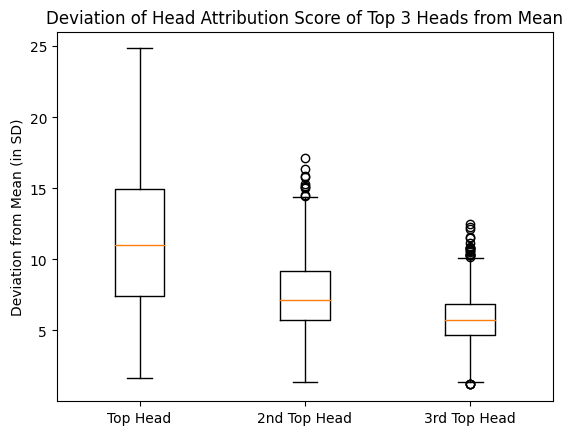

In [21]:
# box plot the deviation of the top 3 heads
from matplotlib import pyplot as plt
plt.boxplot([top_head_1_deviation, top_head_2_deviation, top_head_3_deviation])
plt.ylabel("Deviation from Mean (in SD)")
plt.xticks([1, 2, 3], ["Top Head", "2nd Top Head", "3rd Top Head"])
plt.title("Deviation of Head Attribution Score of Top 3 Heads from Mean")
plt.savefig("deviation_boxplot.pdf")

In [9]:
# Convert top_heads into a list of lists
top_heads = top_heads.tolist()
print(top_heads)

[[468, 410, 496], [538, 492, 517], [538, 360, 88], [538, 88, 123], [538, 504, 360], [468, 410, 496], [538, 517, 88], [538, 517, 88], [538, 517, 88], [538, 88, 517], [410, 468, 496], [538, 559, 88], [468, 496, 619], [517, 333, 476]]


In [13]:
from collections import Counter
head_counts = Counter(top_heads.flatten().tolist())
print(head_counts)
print(top_heads.shape)

# tensor([[468, 410, 496],
        # [538, 492, 517],
        # [538, 360,  88],
        # [538,  88, 123],
        # [538, 504, 360],
        # [468, 410, 496],
        # [538, 517,  88],
        # [538, 517,  88],
        # [538, 517,  88],
        # [538,  88, 517],
        # [468, 410, 496],
        # [538, 559,  88],
        # [468, 496, 619],
        # [517, 333, 492]])

# Counter({538: 9, 88: 7, 517: 6, 468: 4, 496: 4, 410: 3, 492: 2, 360: 2, 123: 1, 504: 1, 559: 1, 619: 1, 333: 1})
# Counter({538: 9, 88: 7, 517: 6, 468: 4, 496: 4, 410: 3, 492: 2, 360: 2, 123: 1, 504: 1, 559: 1, 619: 1, 333: 1})
# Counter({538: 9, 88: 7, 517: 6, 468: 4, 496: 4, 410: 3, 360: 2, 492: 1, 123: 1, 504: 1, 559: 1, 619: 1, 333: 1, 476: 1})
# Counter({88: 11, 123: 10, 106: 4, 538: 3, 468: 2, 517: 2, 619: 1, 410: 1, 453: 1, 422: 1, 466: 1, 504: 1, 360: 1, 401: 1, 400: 1, 361: 1})

Counter({106: 6, 88: 6, 623: 3, 668: 2, 658: 2, 575: 2, 548: 2, 325: 2, 409: 1, 259: 1, 661: 1, 695: 1, 639: 1, 676: 1, 568: 1, 393: 1, 357: 1, 113: 1, 532: 1, 457: 1, 645: 1, 538: 1, 492: 1, 454: 1, 364: 1, 304: 1, 14: 1, 423: 1, 98: 1, 123: 1, 666: 1, 361: 1, 655: 1, 535: 1, 455: 1, 85: 1, 606: 1, 469: 1, 605: 1, 644: 1})
torch.Size([19, 3])


In [26]:
head_number = 106

positive_examples = []
negative_examples = []
for i, example in enumerate(trunc_prompts):
    if head_number in top_heads[i]:
        positive_examples.append(trunc_prompts[i])
    else:
        negative_examples.append(trunc_prompts[i])


In [17]:
# Get last key
last_key = list(head_attribution_dict.keys())[-1]
print(last_key)

(35, 4638)


In [30]:
# TODO: Replace actual word

newline = "\n"
gpt_4_prompt = \
f'We are studying attention heads in a transformer architecture neural network. Each attention head looks for some particular thing in a short document.\n\
This attention head in particular helps to predict that the next word is "power", but it is only active in some documents and not others. Look at the documents and explain when the attention head is active.\n\
Examples where the attention head is active: """\n\
*{f"{newline}*".join(positive_examples)}\n\
"""\n\
Examples where the attention head is inactive: """\n\
*{f"{newline}*".join(negative_examples)}\n\
"""\n\
Explanation: This attention head is active when the document\
'

# gpt_4_prompt = \
# f'We are studying attention heads in a transformer architecture neural network. Each attention head looks for some particular thing in a short document.\n\
# This attention head in particular helps to predict that the next word is "only", but it is only active in some documents and not others.\n\
# Explanation: This attention head is active when the document contains a context where the word "only" is used to emphasize the exclusivity or limitation of a particular aspect or condition. In the active examples, "only" highlights a unique attribute, such as being the only species that kills for revenge, or a service being only available in specific countries. In the inactive examples, the word "only" is not present, and the context does not emphasize any exclusiveness or limitation that would activate this attention head.\n\
# Using the explanation, generate three documents where this attention head is active, and three documents where it is inactive. Make sure that each of the documents would still make sense if you added the word "only" immediately after.\n\
# '

print(gpt_4_prompt)

We are studying attention heads in a transformer architecture neural network. Each attention head looks for some particular thing in a short document.
This attention head in particular helps to predict that the next word is "power", but it is only active in some documents and not others. Look at the documents and explain when the attention head is active.
Examples where the attention head is active: """
* President Trump Donald John TrumpBiden on Trump's refusal to commit to peaceful transfer of
*About ARM ARM designs the technology that
*ohydrates have become the ‘culp
* Donald John TrumpBiden on Trump's refusal to commit to peaceful transfer of power: 'What country are we in?' Romney: 'Unthinkable and unacceptable' to not commit to peaceful transition of
* their staying
* Conference with 5,500 attendees, 600 technical sessions and 200 exhibitors, focused on artificial intelligence, VR and self-driving cars.  Unveiled the NVIDIA Tesla P100 GPU, the most
"""
Examples where the attentio

In [1]:
import openai
import os
openai.api_key = os.getenv("OPENAI_API_KEY")

In [2]:
class GPT4UsageTracker:
    def __init__(self):
        self.PROMPT_COST = 0.03/1000
        self.RESPONSE_COST = 0.06/1000
        # Check if gpt4_usage.json exists
        if os.path.exists("gpt4_usage.json"):
            self.data = json.load(open("gpt4_usage.json"))
        else:
            self.data = []
        self.prompt_tokens_total = sum([data["response"]["usage"]["prompt_tokens"] for data in self.data])
        self.response_tokens_total = sum([data["response"]["usage"]["completion_tokens"] for data in self.data])
        print(f"Total cost: {self.prompt_tokens_total*self.PROMPT_COST + self.response_tokens_total*self.RESPONSE_COST}")

    def add_usage(self, response, prompt):
        self.data.append({"response": response, "prompt": prompt})
        self.prompt_tokens_total += response["usage"]["prompt_tokens"]
        self.response_tokens_total += response["usage"]["completion_tokens"]
        print(f"Cost of this call: {response['usage']['prompt_tokens']*self.PROMPT_COST + response['usage']['completion_tokens']*self.RESPONSE_COST}")
        print(f"Total cost: {self.prompt_tokens_total*self.PROMPT_COST + self.response_tokens_total*self.RESPONSE_COST}")
        self._save()

    def _save(self):
        json.dump(self.data, open("gpt4_usage.json", "w"))

tracker = GPT4UsageTracker()

Total cost: 0.0


In [3]:
gpt_4_prompt = "Why did the chicken cross the road?"

In [5]:
actually_run = True
print_prompt = True
print_response = True

if actually_run:
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[{"role": "user", "content": gpt_4_prompt}],
        max_tokens=200,
    )
    response_dict = response.to_dict_recursive()

    tracker.add_usage(response_dict, gpt_4_prompt)

    if print_prompt:
        print("----------PROMPT----------")
        print(gpt_4_prompt)
    if print_response:
        print("----------RESPONSE----------")
        print(response_dict["choices"][0]["message"]["content"])


----------PROMPT----------
Why did the chicken cross the road?
----------RESPONSE----------
To get to the other side.


In [148]:
# neuron = (34, 4954) # number neuron
# prompts = [
#     "When I was writing my first book, I was going from eleven at night till",
#     "The most merciful thing that the large family does to one of its infant members is to kill it. The same factors which create the terrible infant mortality rate, and which swell the death rate of children between the ages of one and",
#     "The federal government and plaintiffs including the North Carolina NAACP and the League of Women Voters argued during a hearing last month that three important parts of the law—a reduction in early voting from seventeen to",
#     "Serial killers, they concluded, fall into one of",
#     "If no candidate had an outright majority—and the framers assumed that this would be normal once George Washington had passed from the scene—the House would choose among the top five, later reduced to the top",
#     "If you listen to most so-called survival experts, they often suggest that your BOB should contain enough supplies to last for at least seventy-",
#     "The notion that our outlook on life is connected to our well-being is not a new one. In the nineteen-sixties, the University of Connecticut psychologist Julian Rotter proposed that we could view external events in one of",
# ]


# neuron = (31, 894) # an-neuron
# # These prompts don't actually give "an" as a top prediction, probably because of the shorter context windows
# prompts = [
#     "The pet peeve of Steresoscopic 3D film-making, unless done correctly. (Bokeh) This technique is worth exploring in",
#     "Parents often disagree about homework, chores, and technology usage, and that's okay. However, each parent should have",
#     "But I think a lot of teams haven't realized when to pick him and how to play him just yet, so maybe we will have",
#     "The first part of the talk revisited some of the things Jon talked about on Friday night, with",
#     "However, as far local LAN tournaments, there was the first ChiCraft this past winter, and we'll certainly be doing another one over the summer (June/July-ish?). There isn't"
# ]

# issue neuron
neuron = (35, 4518)
prompts = [
    "You can also invest in bonds from foreign governments. Many governments",
    "Squanchy, Birdperson, and Rick were once freedom fighters against the Galactic Federation's oppression; their \"crimes\" led the Galactic Federation to",
    "The disadvantage is that the one holding the reserves would be paying a high opportunity cost. Why would you put so much money aside? There needs to be some gain opportunity for private individuals to voluntary",
    "As of March 2008, this had declined by 24%, to 53 months. 71% of this debt is due in less than 5 years; 39% is due in less than a year.In the Clinton/Rubin era, the Treasury stopped",
]


tokens = model.to_tokens(prompts, prepend_bos=True).to(device=device)
original_logits, cache = model.run_with_cache(tokens)

In [16]:
def get_head_attribution(cache, tokens, neuron):
    # Get prompt lengths
    pad_token = bos_token = 50256 # This is true for GPT-2
    prompt_lengths = (torch.logical_and(tokens != pad_token, tokens != bos_token)).sum(dim=-1)

    # Get the correct last-seq for each prompt (since they are padded, the last seq position differs for each prompt)
    head_output = cache.stack_head_results()
    expanded_index_tensor = prompt_lengths.unsqueeze(0).unsqueeze(-1).unsqueeze(-1).expand(head_output.shape[0], head_output.shape[1], 1, head_output.shape[-1])
    head_output_last_seq = torch.gather(head_output, 2, expanded_index_tensor).squeeze(2)

    # Get dot product of neuron with each head's output

    layer, no = neuron
    neuron_w_in = model.W_in[layer, :, no]
    head_attribution = einsum("head batch weight, weight->batch head", head_output_last_seq, neuron_w_in)
    head_attribution = head_attribution[:, :layer*model.cfg.n_heads] # Filter for only heads before the neuron
    return head_attribution # Shape [batch, head]

# head_attribution = get_head_attribution(cache, tokens, neuron)
# _, top_heads = torch.topk(head_attribution, k=3, dim=-1)
# print(top_heads)

In [168]:
print(len(prompts))
head_attribution_lh = einops.rearrange(head_attribution, "batch (layer head) -> batch layer head", head=model.cfg.n_heads)
for prompt_index in range(len(prompts)):
    imshow(head_attribution_lh[prompt_index, :, :], title=f"{prompts[prompt_index][-50:]}")

4


In [7]:
from datasets import load_dataset
dataset = load_dataset("NeelNanda/pile-10k", split="train")

Using custom data configuration NeelNanda--pile-10k-72f566e9f7c464ab
Found cached dataset parquet (/Users/clementneo/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [8]:
with open("neuron_max_acts.json", "r") as f:
    neuron_max_acts_load = json.load(f)

In [57]:
neuron = (35, 3724)
neuron_acts_35_3724 = neuron_max_acts_load['(35, 3724)']
# Get the top 20 examples
num_samples = 20
neuron_acts_35_3724 = [x + [i] for i, x in enumerate(neuron_acts_35_3724)]
sorted_acts_35_3724 = sorted(neuron_acts_35_3724, key=lambda x: x[0], reverse=True)
print(sorted_acts_35_3724)
top_examples_indices = [x[2] for x in sorted_acts_35_3724[:num_samples]]
top_examples_pos = [x[1] for x in sorted_acts_35_3724[:num_samples]]
examples = []
for index in top_examples_indices:
    examples.append(dataset[index]['text'])
print(examples)

# Then run head attribution
# Truncate examples to the right position
for i, example in enumerate(examples):
    tokens = model.to_tokens(example, prepend_bos=True).to(device=device)
    tokens = tokens[:, :top_examples_pos[i]+1]
    tokens = tokens[:, -50:]
    examples[i] = model.to_string(tokens)[0]

# for i, example in enumerate(examples):
#     print("--> ", i)
#     print(example)

tokens = model.to_tokens(examples, prepend_bos=True).to(device=device)
print(tokens.shape)
original_logits, cache = model.run_with_cache(tokens)
head_attribution = get_head_attribution(cache, tokens, neuron)
_, top_heads = torch.topk(head_attribution, k=3, dim=-1)
# print(top_heads) # 491, 653, 526 # 491, 526, 496 # 668, 519, 658 # 602, 519, 668 # 668, 519, 602 # 653, 491, 496 # 491, 653, 526 # 668, 491, 434 # 491, 653, 526

[[11.053892135620117, 99, 2659], [10.527321815490723, 757, 5653], [10.241874694824219, 451, 1342], [9.469478607177734, 84, 2715], [8.823227882385254, 176, 5500], [8.733474731445312, 341, 7286], [8.57863998413086, 158, 1037], [8.51498794555664, 32, 6527], [8.206207275390625, 748, 1969], [8.162208557128906, 186, 6202], [8.10352611541748, 1018, 3811], [8.00257682800293, 665, 9757], [7.9617600440979, 284, 8387], [7.916937828063965, 996, 7516], [7.8989362716674805, 34, 4679], [7.798364639282227, 76, 8403], [7.797216892242432, 214, 9910], [7.782955646514893, 523, 8259], [7.721066474914551, 119, 1328], [7.719846725463867, 461, 4224], [7.645995140075684, 208, 3216], [7.5494208335876465, 369, 7414], [7.444610595703125, 800, 6907], [7.428597450256348, 65, 3606], [7.390169143676758, 698, 4952], [7.371682167053223, 411, 8686], [7.347747802734375, 656, 9169], [7.282724857330322, 103, 6739], [7.26452112197876, 292, 5437], [7.196075916290283, 47, 7589], [7.170181751251221, 126, 2810], [7.157305717468

In [66]:
print(top_heads)
# Get the counts of each head appearing
from collections import Counter
head_counts = Counter(top_heads.flatten().tolist())
print(head_counts)

# Get the 668, non-668 examples
non_668_examples = []
good_668_examples = []
for i, example in enumerate(examples):
    # if any of the top heads is 668, then it's a good example
    if 519 in top_heads[i]:
        good_668_examples.append(example)
    else:
        non_668_examples.append(example)


tensor([[668, 602, 496],
        [668, 677, 658],
        [668, 641, 623],
        [602, 519, 668],
        [668, 519, 602],
        [505, 550, 445],
        [688, 355,  60],
        [668, 519, 575],
        [376, 688,  60],
        [448, 413, 668],
        [674, 475, 684],
        [519, 668, 641],
        [668, 684, 685],
        [519, 668, 538],
        [668, 688, 519],
        [623, 658, 378],
        [390, 448, 343],
        [663, 688, 578],
        [491, 505, 602],
        [653, 491, 526]])
Counter({668: 11, 519: 6, 602: 4, 688: 4, 658: 2, 641: 2, 623: 2, 505: 2, 60: 2, 448: 2, 684: 2, 491: 2, 496: 1, 677: 1, 550: 1, 445: 1, 355: 1, 575: 1, 376: 1, 413: 1, 674: 1, 475: 1, 685: 1, 538: 1, 378: 1, 390: 1, 343: 1, 663: 1, 578: 1, 653: 1, 526: 1})


In [67]:
# print the good 668 examples, and the non-668 examples
for i, example in enumerate(good_668_examples):
    print("G --> ", i)
    print(example)
for i, example in numerate(non_668_examples):
    print("N --> ", i)
    print(example)

G -->  0
 which marks the fourth straight season covered by yours truly. I have to confess upfront that I’m feeling some trepidation at the start here: Partly because I felt the quality and chemistry of the competitors on Season Six set the bar awfully
G -->  1
 showed the captain what she was made of.

Elena had her father's broomstick and she was going to have good luck with it. She could feel it in her bones. Elena walked to the Quiddith pitch with her head held
G -->  2
<|endoftext|>Youth unemployment in Victoria hits 15-year high

Henrietta Cook, state political reporter

Youth unemployment has leapt to a 15-year
G -->  3
 tomcat named Tuffy with keeping her mother alive and able to live on her own for several years. “My mother was elderly and had insulin-dependent diabetes,” Matson says. “Often, her blood sugar would go dangerously
G -->  4
 keep fighting as others before us have fought in the face of seemingly insurmountable odds.

So I'll see you on Facebook whenever the mood h

In [47]:
utils.test_prompt(examples[3], " high", model, prepend_bos=True, top_k=5)

Tokenized prompt: ['<|endoftext|>', 'm', ' feeling', ' some', ' tre', 'p', 'idation', ' at', ' the', ' start', ' here', ':', ' Part', 'ly', ' because', ' I', ' felt', ' the', ' quality', ' and', ' chemistry', ' of', ' the', ' competitors', ' on', ' Season', ' Six', ' set', ' the', ' bar', ' awfully']
Tokenized answer: [' high']


Performance on answer token:
Rank: 1        Logit: 21.38 Prob: 27.46% Token: | high|

Top 0th token. Logit: 22.34 Prob: 71.76% Token: | low|
Top 1th token. Logit: 21.38 Prob: 27.46% Token: | high|
Top 2th token. Logit: 15.91 Prob:  0.12% Token: |,|
Top 3th token. Logit: 15.59 Prob:  0.08% Token: | too|
Top 4th token. Logit: 15.31 Prob:  0.06% Token: | lower|


Ranks of the answer tokens: [(' high', 1)]

In [59]:
# for neuron in tqdm(neurons):
#     # Load and Truncate Prompts (slightly cursed way of string -> token -> truncated tokens -> string)
#     trunc_prompts, prompts_metadata = data.load_truncated_prompts(model, neuron)
#     examples = trunc_prompts

#     # Run head attribution
#     tokens = model.to_tokens(trunc_prompts, prepend_bos=True).to(device=device)
#     original_logits, cache = model.run_with_cache(tokens, )

#     # # Prepare prompts by heads
#     head_attribution = get_head_attribution(cache, tokens, neuron)
#     head_attribution_lh = einops.rearrange(head_attribution, "batch (layer head) -> batch layer head", head=model.cfg.n_heads)
for i, prompt_index in enumerate(range(len(examples))):
    try:
        fig = imshow_fig(head_attribution_lh[prompt_index, :, :], title=f"...{examples[prompt_index][-50:]}")
        fig.write_image(f"heads/head_sparsity_{i}.pdf",engine='orca')
        fig.show()
    except:
        continue# fig.write_image(f"heads/head_sparsity_{i}.png")

In [44]:
!pip install --upgrade kaleido=


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [45]:
head_attribution_lh = einops.rearrange(head_attribution, "batch (layer head) -> batch layer head", head=model.cfg.n_heads)
for prompt_index in range(len(examples)):
    imshow(head_attribution_lh[prompt_index, :, :], title=f"{examples[prompt_index][-50:]}")

In [20]:
head_attribution_lh = einops.rearrange(head_attribution, "batch (layer head) -> batch layer head", head=model.cfg.n_heads)
for prompt_index in range(len(examples)):
    imshow(head_attribution_lh[prompt_index, :, :], title=f"{examples[prompt_index][-50:]}")

In [ ]:
text = dataset[50]['text']
tokens = model.to_tokens(text, prepend_bos=True,).to(device=device)

torch.Size([1, 959])
At our best, we motivate ourselves every day to get dressed and go to work or school. Although there are larger incentives at work, it's our own volition that powers us through our innumerable daily tasks.

If we could learn to control the motivational centers of our brains that drive volition, would it lead us toward healthier, more productive lives? Using a new brain imaging strategy, Duke University scientists have now taken a first step in understanding how to manipulate specific neural circuits using thoughts and imagery.

The technique, which is described in the March 16 issue of the journal Neuron, is part of a larger approach called 'neurofeedback,' which gives participants a dynamic readout of brain activity, in this case from a brain area critical for motivation.

"These methods show a direct route for manipulating brain networks centrally involved in healthy brain function and daily behavior," said the study's senior investigator R. Alison Adcock, an ass

In [170]:
text = dataset[10]['text']
tokens = model.to_tokens(prompt, prepend_bos=True,).to(device=device)
original_logits, cache = model.run_with_cache(tokens)

KeyboardInterrupt: 

In [146]:
x = cache.decompose_resid(return_labels=True)
print(x[1])

['embed', 'pos_embed', '0_attn_out', '0_mlp_out', '1_attn_out', '1_mlp_out', '2_attn_out', '2_mlp_out', '3_attn_out', '3_mlp_out', '4_attn_out', '4_mlp_out', '5_attn_out', '5_mlp_out', '6_attn_out', '6_mlp_out', '7_attn_out', '7_mlp_out', '8_attn_out', '8_mlp_out', '9_attn_out', '9_mlp_out', '10_attn_out', '10_mlp_out', '11_attn_out', '11_mlp_out', '12_attn_out', '12_mlp_out', '13_attn_out', '13_mlp_out', '14_attn_out', '14_mlp_out', '15_attn_out', '15_mlp_out', '16_attn_out', '16_mlp_out', '17_attn_out', '17_mlp_out', '18_attn_out', '18_mlp_out', '19_attn_out', '19_mlp_out', '20_attn_out', '20_mlp_out', '21_attn_out', '21_mlp_out', '22_attn_out', '22_mlp_out', '23_attn_out', '23_mlp_out', '24_attn_out', '24_mlp_out', '25_attn_out', '25_mlp_out', '26_attn_out', '26_mlp_out', '27_attn_out', '27_mlp_out', '28_attn_out', '28_mlp_out', '29_attn_out', '29_mlp_out', '30_attn_out', '30_mlp_out', '31_attn_out', '31_mlp_out', '32_attn_out', '32_mlp_out', '33_attn_out', '33_mlp_out', '34_attn_ou